## Music Recommender using Facial Emotion Detection

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pickle
import matplotlib.pyplot as plt


#music recommendor
from music_recommender import MusicRecommender
import logging

import numpy as np
import cv2
import time
from concurrent.futures import ThreadPoolExecutor

2025-05-17 16:32:26.302080: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 16:32:26.452028: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 16:32:26.596148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747479746.708817   31957 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747479746.743282   31957 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747479747.010079   31957 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

#### emotion detection


##### Dataset preparation

In [ ]:
# Define paths to your dataset (adjust these to your actual paths)
train_dir = 'fer-2013/train'
test_dir = 'fer-2013/   test'

# Constants
BATCH_SIZE = 32
IMG_SIZE = (48, 48)  # FER-2013 images are 48x48 pixels

# Load the dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale',  # FER-2013 is grayscale
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale',
    label_mode='categorical'
)

# Check the class names
class_names = train_dataset.class_names
print("Emotion classes:", class_names)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


#### data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


### build the cnn 

In [15]:

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(48, 48, 1)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # FER-2013 has 7 classes
])

# --- Compile Model ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Show model summary
model.summary()

/home/sanyam/Documents/machine learning /minor project/moodtunes/moodtunes/backend/venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### train the model

In [44]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Number of epochs
epochs = 50

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)


with open('history.pkl','wb') as f:
    pickle.dump(history.history,f)

# Save the model
model.save('emotion_cnn_model.h5')


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.2731 - loss: 1.7727 - val_accuracy: 0.3658 - val_loss: 1.5989
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.3614 - loss: 1.6228 - val_accuracy: 0.4401 - val_loss: 1.4394
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.4267 - loss: 1.4952 - val_accuracy: 0.4907 - val_loss: 1.3247
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.4559 - loss: 1.4111 - val_accuracy: 0.5092 - val_loss: 1.2795
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.4832 - loss: 1.3588 - val_accuracy: 0.5043 - val_loss: 1.3005
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.5002 - loss: 1.3216 - val_accuracy: 0.5098 - val_loss: 1.2586
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.5106 - loss: 1.2933 - val_accuracy: 0.5315 - val_loss: 1.2189
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 86ms/step - accuracy: 0.5160 - loss: 1.2669 - 

In [11]:
model.save("emotion_cnn_model.keras")

### evaluation and visualization

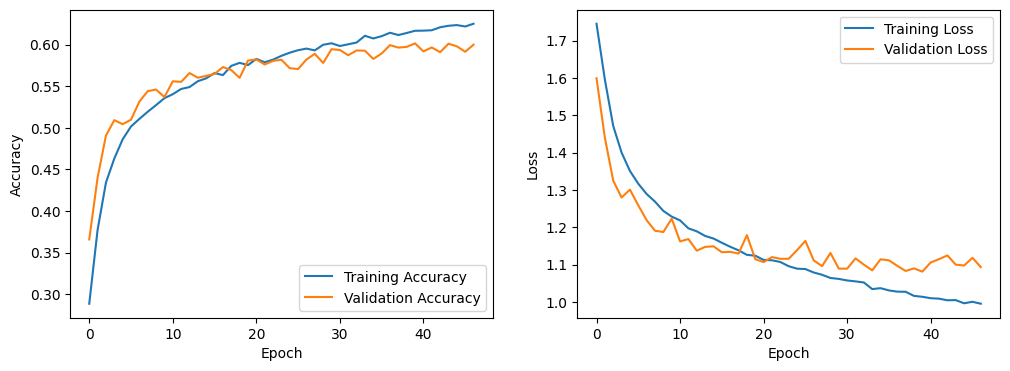

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2455 - loss: 25.4997
Test accuracy: 0.24


In [16]:
# Plot training history
model = tf.keras.models.load_model("emotion_cnn_model.keras")
with open('history.pkl','rb') as f:
    history = pickle.load(f)
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

# Evaluate on test set
test_loss, test_acc = model.evaluate(validation_dataset)
print(f'Test accuracy: {test_acc:.2f}')

##### prediction function

In [5]:

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def predict_emotion(frame, model):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        return "No face", 0.0

    (x, y, w, h) = faces[0]
    face_roi = gray[y:y+h, x:x+w]

    resized = cv2.resize(face_roi, (48, 48))
    normalized = resized / 255.0
    input_tensor = np.expand_dims(np.expand_dims(normalized, -1), 0)

    predictions = model.predict(input_tensor, verbose=0)
    print(f"[DEBUG] Raw predictions: {predictions[0]}")

    return class_names[np.argmax(predictions[0])], np.max(predictions[0])


### detect emotion and get recommendation with lastfm api

In [6]:
import cv2
import numpy as np
import time
from music_recommender import MusicRecommender




def initialize_camera():
    """Initialize camera with better settings"""
    for camera_index in [0, 1, 2]:
        cap = cv2.VideoCapture(camera_index)  
        if cap.isOpened():
            # Set optimal camera settings
            cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
            cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
            cap.set(cv2.CAP_PROP_FPS, 30)
            print(f"Using camera at index {camera_index}")
            return cap
        cap.release()
    raise RuntimeError("Could not open any camera")

def main():
    model = tf.keras.models.load_model('/home/sanyam/Documents/machine learning /minor project/moodtunes/moodtunes/backend/model/emotion_cnn_model.keras')
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    cap = initialize_camera()
    recommender = MusicRecommender(api_key="8f2e5122c0034cb7c1eaf3a0e21c7ee5", api_secret="fd5d0aae8dbc49c3d514b0dfc078091f")
    
    last_emotion = None
    last_recommendations = []
    processing_interval = 30  # Process every 30 frames (~1 second at 30fps)
    frame_count = 0

    try:
        while True:
            start_time = time.time()
            
            # Read frame
            ret, frame = cap.read()
            if not ret:
                print("Frame capture failed, retrying...")
                time.sleep(0.1)
                continue
            
            frame_count += 1
            
            # Process at intervals
            if frame_count % processing_interval == 0:
                try:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    resized = cv2.resize(gray, (48, 48))
                    cv2.imshow('Processed Face', resized)

                    current_emotion, confidence = predict_emotion(frame, model)
                    #debug print
                    print(f"[DEBUG] Current: {current_emotion} (Confidence: {confidence:.2f}) | Last: {last_emotion}")
                    if(confidence < 0.3):
                        print(f"[DEBUG] Low {confidence:.2f}), skipping...")
                        continue  # skipping weak predictions

                    if current_emotion != last_emotion:
                        print(f"\nDetected: {current_emotion} (Confidence: {confidence:.0%})")
                        
                        # Get recommendations (with fallback to cached)
                        try:
                            recommendations = recommender.get_recommendations(current_emotion)
                            if recommendations:
                                last_recommendations = recommendations
                                print("=== Recommended Songs ===")
                                for i, (song, artist) in enumerate(recommendations, 1):
                                    print(f"{i}. {song} by {artist}")
                            elif last_recommendations:
                                print("(Using cached recommendations)")
                                for i, (song, artist) in enumerate(last_recommendations, 1):
                                    print(f"{i}. {song} by {artist}")
                        except Exception as e:
                            print(f"Recommendation error: {str(e)}")
                            
                        last_emotion = current_emotion
                
                except Exception as e:
                    print(f"Processing error: {str(e)}")
            
            # Display
            display_text = f"Mood: {last_emotion}" if last_emotion else "Detecting..."
            cv2.putText(frame, display_text, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            cv2.imshow('Emotion Music', frame)
            
            # Maintain consistent FPS
            elapsed = time.time() - start_time
            delay = max(1, int((1/30 - elapsed) * 1000))  # Target 30 FPS
            if cv2.waitKey(delay) & 0xFF == ord('q'):
                break
                
    finally:
        cap.release()
        cv2.destroyAllWindows()
        cv2.destroyWindow("Processed Face")
        print("App closed cleanly")

if __name__ == "__main__":
    main()

Using camera at index 0
[DEBUG] Raw predictions: [0.1561205  0.14160897 0.1463152  0.15503582 0.13460651 0.12771395
 0.13859911]
[DEBUG] Current: angry (Confidence: 0.16) | Last: None
[DEBUG] Low 0.16), skipping...
[DEBUG] Raw predictions: [0.1570559  0.14154743 0.14653476 0.15480818 0.13444553 0.12726325
 0.13834487]
[DEBUG] Current: angry (Confidence: 0.16) | Last: None
[DEBUG] Low 0.16), skipping...
[DEBUG] Raw predictions: [0.15878949 0.14035818 0.14546782 0.15691218 0.13452268 0.12730642
 0.13664328]
[DEBUG] Current: angry (Confidence: 0.16) | Last: None
[DEBUG] Low 0.16), skipping...
[DEBUG] Raw predictions: [0.15854825 0.13991696 0.1440698  0.15701541 0.13520753 0.12759326
 0.13764875]
[DEBUG] Current: angry (Confidence: 0.16) | Last: None
[DEBUG] Low 0.16), skipping...
[DEBUG] Raw predictions: [0.15825693 0.13963108 0.14405079 0.15729827 0.13460594 0.12754814
 0.13860889]
[DEBUG] Current: angry (Confidence: 0.16) | Last: None
[DEBUG] Low 0.16), skipping...
[DEBUG] Raw predictio

error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window_QT.cpp:578: error: (-27:Null pointer) NULL guiReceiver (please create a window) in function 'cvDestroyWindow'


### webcam 

In [9]:
''' import cv2
import numpy as np



def preprocess_frame_for_cnn(frame, img_size=(48, 48)):
    """Convert webcam frame to CNN input format"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, img_size)
    normalized = resized / 255.0
    input_tensor = np.expand_dims(np.expand_dims(normalized, -1), 0)
    return input_tensor

cap = cv2.VideoCapture(0)
last_emotion = None

while True:
    ret, frame = cap.read()
    if not ret:
        continue
    
    # Process every second (30 frames at ~30fps)
    if cv2.getTickCount() % 30 == 0:
        try:
            # Preprocess and predict
            input_tensor = preprocess_frame_for_cnn(frame)
            predictions = model.predict(input_tensor)
            current_emotion = class_names[np.argmax(predictions)]
            
            if current_emotion != last_emotion:
                print(f"\nNew emotion detected: {current_emotion}")
                recommendations = recommender.get_recommendations(current_emotion)
                recommender.print_recommendations(recommendations)
                last_emotion = current_emotion
                
        except Exception as e:
            print(f"Error: {str(e)}")
    
    # Display
    display_text = f"Current Mood: {last_emotion}" if last_emotion else "Analyzing..."
    cv2.putText(frame, display_text, (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.imshow('Emotion Music Recommender', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
'''

' import cv2\nimport numpy as np\n\n\n\ndef preprocess_frame_for_cnn(frame, img_size=(48, 48)):\n    """Convert webcam frame to CNN input format"""\n    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n    resized = cv2.resize(gray, img_size)\n    normalized = resized / 255.0\n    input_tensor = np.expand_dims(np.expand_dims(normalized, -1), 0)\n    return input_tensor\n\ncap = cv2.VideoCapture(0)\nlast_emotion = None\n\nwhile True:\n    ret, frame = cap.read()\n    if not ret:\n        continue\n\n    # Process every second (30 frames at ~30fps)\n    if cv2.getTickCount() % 30 == 0:\n        try:\n            # Preprocess and predict\n            input_tensor = preprocess_frame_for_cnn(frame)\n            predictions = model.predict(input_tensor)\n            current_emotion = class_names[np.argmax(predictions)]\n\n            if current_emotion != last_emotion:\n                print(f"\nNew emotion detected: {current_emotion}")\n                recommendations = recommender.get_recom